In [1]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            min_of_col = df[col].min()
            max_of_col = df[col].max()
            if str(col_type)[:3] == 'int':
                if min_of_col > np.iinfo(np.int8).min and max_of_col < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_of_col > np.iinfo(np.int16).min and max_of_col < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_of_col > np.iinfo(np.int32).min and max_of_col < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_of_col > np.iinfo(np.int64).min and max_of_col < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if min_of_col > np.finfo(np.float16).min and max_of_col < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_of_col > np.finfo(np.float32).min and max_of_col < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train_tr = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')

print(train_tr.shape)
train_tr = reduce_mem_usage(train_tr)
train_tr.head()

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_identity = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
print(train_identity.shape)
train_identity = reduce_mem_usage(train_identity)
train_identity.head()

(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
train = pd.merge(train_tr, train_id, how = 'left')
print(train.shape)

del train_tr, train_id
train.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
test_tr = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
print(test_tr.shape)
test_tr = reduce_mem_usage(test_tr)

(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%


In [8]:
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
print(test_id.shape)
test_id = reduce_mem_usage(test_id)

(141907, 41)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%


In [9]:
test = pd.merge(test_tr, test_id, how='left')
test.columns = train.drop('isFraud', axis=1).columns

print(test.shape)
del test_tr, test_id
test.head()

(506691, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
nan_percentage_train = (train.isnull().mean()) * 100

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Percentage of null values in each column:")
    print(nan_percentage_train)

Percentage of null values in each column:
TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
dist1             59.652352
dist2             93.628374
P_emaildomain     15.994852
R_emaildomain     76.751617
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.214888
D2                47.549192
D3                44.514851
D4    

In [11]:
nan_percentage_test = (test.isnull().mean()) * 100

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Percentage of null values in each column:")
    print(nan_percentage_test)

Percentage of null values in each column:
TransactionID      0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.707944
card3              0.592472
card4              0.609050
card5              0.897391
card6              0.593458
addr1             12.948523
addr2             12.948523
dist1             57.474279
dist2             92.809030
P_emaildomain     13.655660
R_emaildomain     73.184840
C1                 0.000592
C2                 0.000592
C3                 0.000592
C4                 0.000592
C5                 0.000592
C6                 0.000592
C7                 0.000592
C8                 0.000592
C9                 0.000592
C10                0.000592
C11                0.000592
C12                0.000592
C13                0.937060
C14                0.000592
D1                 1.190272
D2                46.333762
D3                40.091890
D4                15.167232
D5    

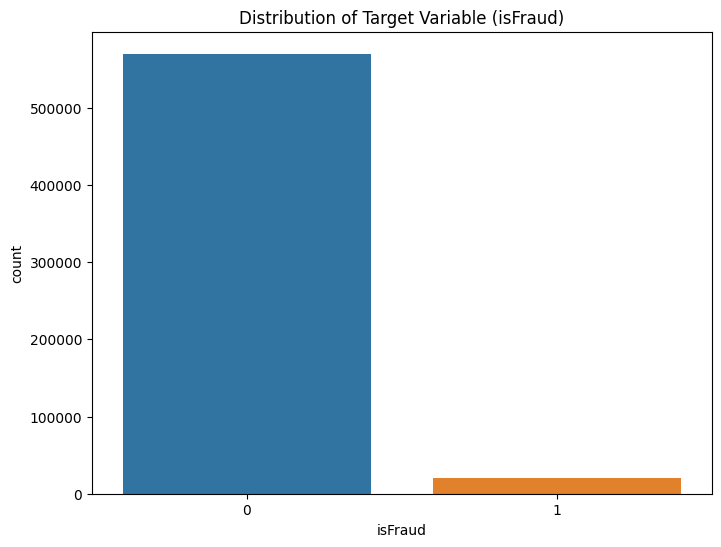

In [12]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'isFraud', data = train)
plt.title('Distribution of Target Variable (isFraud)')
plt.show()

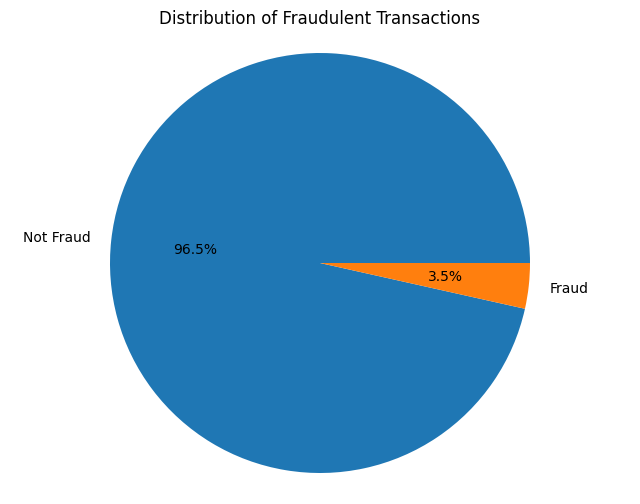

In [13]:
isFraud = train.isFraud.value_counts()

plt.figure(figsize = (8, 6))
plt.pie(isFraud, labels = ['Not Fraud', 'Fraud'], autopct = '%0.1f%%')
plt.axis('equal')
plt.title("Distribution of Fraudulent Transactions")
plt.show()

In [14]:
column_to_drop = nan_percentage_train[nan_percentage_train > 80].index

cleaned_train = train.drop(columns = column_to_drop)
cleaned_train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
cleaned_test = test.drop(columns = column_to_drop)
cleaned_test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.687500,C,13832,375.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.171875,C,3154,408.0,185.0,mastercard,224.0,debit,...,507.0,New,NotFound,chrome 43.0 for android,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000000,W,16661,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def get_feature_types(df):
    
    num_features = df.select_dtypes(include = [np.number])
    cat_features = df.select_dtypes(exclude = [np.number])
    return num_features, cat_features

# Excluding the isFraud column so we can use the pipelines for the train and test sets
y = cleaned_train.isFraud
X = cleaned_train.drop('isFraud', axis=1)

In [17]:
num_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, get_feature_types(X)[0].columns),
        ('cat', cat_pipeline, get_feature_types(X)[1].columns)
    ])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=0)

In [19]:
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.05)

In [20]:
rfc_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

In [21]:
X_train_trans = preprocessor.fit_transform(X_train)

X_train_trans = pd.DataFrame(X_train_trans)

In [22]:
xgb_pipeline = Pipeline(steps=[
    ('model', xgb_model)
])

xgb_pipeline.fit(X_train_trans, y_train)


Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [23]:
X_train_trans1 = X_train_trans.copy()

In [24]:
rfc_pipeline = Pipeline(steps=[
    ('model', rfc_model)
])

rfc_pipeline.fit(X_train_trans1, y_train)

Pipeline(steps=[('model', RandomForestClassifier(random_state=0))])

In [25]:
X_valid_trans = preprocessor.transform(X_valid)

X_valid_trans = pd.DataFrame(X_valid_trans)

In [26]:
xgb_preds = xgb_pipeline.predict_proba(X_valid_trans)[:, 1]
xgb_roc_auc = roc_auc_score(y_valid, xgb_preds)
print("ROC AUC Score of the XGB classifier:", xgb_roc_auc)

ROC AUC Score of the XGB classifier: 0.9497693434033979


In [27]:
rfc_preds = rfc_pipeline.predict_proba(X_valid_trans)[:, 1]
rfc_roc_auc = roc_auc_score(y_valid, rfc_preds)
print("ROC AUC Score of the Random Forest Classifier:", rfc_roc_auc)

ROC AUC Score of the Random Forest Classifier: 0.9321423605354089


In [28]:
test = preprocessor.transform(cleaned_test)

test = pd.DataFrame(test)

In [29]:
X_valid_trans.head()

,0,1,2,3,4,5,6,7,8,9,...,349,350,351,352,353,354,355,356,357,358
0,-1.686819,-1.544012,-0.459201,-0.019266,1.407194,-0.281683,0.649829,-0.226664,0.078684,3.002393e-16,...,0.0,0.0,0.0,78.0,1.0,0.0,1.0,1.0,0.0,1709.0
1,1.612689,1.678340,-0.075580,-0.403599,-1.076111,-0.281683,-0.810368,-1.144054,0.078684,1.538854e+00,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
2,0.265041,0.217811,-0.255924,0.587629,0.877337,2.811606,0.601156,-0.070291,-10.541947,3.002393e-16,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
3,-0.958953,-1.031861,1.104471,0.493382,1.183761,-0.281683,-0.104606,1.566416,0.078684,3.002393e-16,...,1.0,1.0,1.0,100.0,1.0,0.0,1.0,0.0,1.0,1669.0
4,1.041012,1.051103,-0.430208,-0.182669,0.577298,-0.281683,0.649829,-0.278789,0.078684,-4.598045e-01,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0


In [30]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,349,350,351,352,353,354,355,356,357,358
0,2.236196,2.388684,-0.430208,0.104357,-1.605967,-0.281683,0.649829,-1.258728,0.078684,-0.497834,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
1,2.236202,2.388693,-0.359126,-1.147582,-1.605967,-0.281683,0.649829,0.086082,0.078684,-0.485157,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
2,2.236208,2.388703,0.149589,-1.105966,1.349740,-0.281683,0.649829,1.889587,0.078684,10.636339,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
3,2.236214,2.388703,0.624945,0.222676,-0.016397,-0.281683,-0.810368,-0.893857,0.078684,-0.430226,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
4,2.236220,2.388705,-0.280161,1.656581,0.570914,-0.281683,-2.002862,-0.278789,0.078684,-0.476706,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0


In [31]:
X_train_trans

,0,1,2,3,4,5,6,7,8,9,...,349,350,351,352,353,354,355,356,357,358
0,-1.120421,-1.148008,-0.421282,1.221453,1.164609,2.811606,-1.491793,5.925861e-16,0.000000,3.002393e-16,...,0.0,0.0,0.0,46.0,0.0,0.0,1.0,1.0,0.0,1547.0
1,0.316513,0.269795,-0.317428,1.673921,-0.476032,-0.281683,0.649829,3.571291e-01,0.078684,-4.767064e-01,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
2,0.116711,0.103496,-0.113369,-0.403599,-1.076111,-0.281683,-0.810368,8.608206e-02,0.078684,3.002393e-16,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
3,-1.648021,-1.508052,-0.480050,0.491750,-0.016397,-0.281683,-0.810368,4.092535e-01,0.078684,3.002393e-16,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
4,-0.298231,-0.340906,-0.455227,-1.548235,-0.016397,-0.281683,-1.783832,2.306583e+00,0.078684,8.950957e-02,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531481,0.378314,0.332059,-0.158976,1.656581,0.570914,-0.281683,-2.002862,-2.787889e-01,0.078684,-4.724809e-01,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
531482,-0.838518,-0.911852,0.529040,-0.298132,-0.942051,-0.281683,0.649829,-1.039806e+00,0.078684,-4.133240e-01,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0
531483,-1.040062,-1.096821,-0.246542,0.844463,-1.605967,-0.281683,0.649829,5.925861e-16,0.000000,3.002393e-16,...,0.0,0.0,0.0,96.0,0.0,0.0,1.0,1.0,1.0,1547.0
531484,0.824336,0.792551,0.816756,-1.114126,-1.203787,-0.281683,0.649829,2.118935e+00,0.078684,-4.386770e-01,...,0.0,0.0,0.0,46.0,1.0,0.0,1.0,0.0,0.0,1547.0


In [32]:
test_preds = xgb_pipeline.predict_proba(test)[:, 1]

submission_df = pd.DataFrame({
    'TransactionID': cleaned_test.TransactionID,
    'isFraud': test_preds
})

submission_df.to_csv('submission.csv', index = False)

print("Submission CSV file generated successfully.")

Submission CSV file generated successfully.
